In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = "../data/"

# Exploratory visualizations of the **YouNiverse** dataset

### Data load

In [2]:
#load data of channel, timeseries and video metadata
channels_df = pd.read_csv(DATA_PATH + "df_channels_en.tsv.gz", sep="\t", compression="gzip")
timeseries_df = pd.read_csv(DATA_PATH + "df_timeseries_en.tsv.gz", sep="\t",compression="gzip", parse_dates=["datetime"])
metadata_df = pd.read_feather(DATA_PATH + "yt_metadata_helper.feather", columns=["categories", "channel_id", "duration", "upload_date", "like_count", "dislike_count", "view_count"])

## Channels' dataframe exploration

In [3]:
channels_df.head()

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


#### Distribution of subscribers over channels

Text(0, 0.5, 'Count')

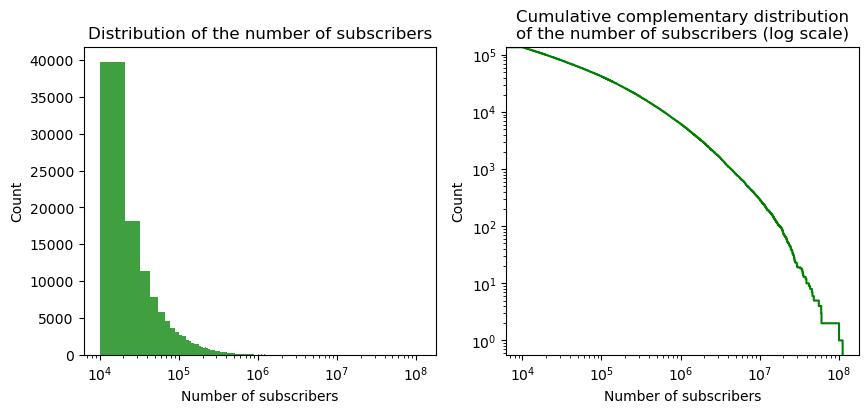

In [4]:
# visualize the distribution of the number of subscribers
f, ax = plt.subplots(1,2, figsize=(10,4))
sns.set_palette("pastel")
sns.histplot(data=channels_df, x="subscribers_cc", ax=ax[0], bins=10000, color="green")
sns.ecdfplot(data=channels_df, x="subscribers_cc", stat="count", log_scale=(True, True), complementary=True, color="green")
ax[0].set_title("Distribution of the number of subscribers")
ax[0].set_xscale("log")
ax[0].set_xlabel("Number of subscribers")
ax[0].set_ylabel("Count")
ax[1].set_title("Cumulative complementary distribution\nof the number of subscribers (log scale)")
ax[1].set_xlabel("Number of subscribers")
ax[1].set_ylabel("Count")

From the histogram, the distribution of the channels' subscribers is clearly skewed. It might resemble a power-law distribution, however from the CFD plot this hypotesis is rejected. 

#### Distribution of videos over channels

Text(0, 0.5, 'Count')

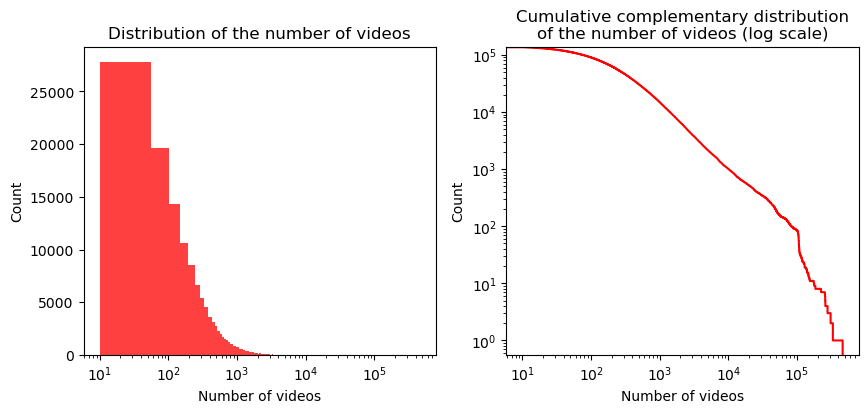

In [5]:
# visualize the distribution of the number of videos
f, ax = plt.subplots(1,2, figsize=(10,4))
sns.set_palette("pastel")
sns.histplot(data=channels_df, x="videos_cc", ax = ax[0], bins=10000, color="red")
sns.ecdfplot(data=channels_df, x="videos_cc", stat="count", log_scale=(True, True), complementary=True, color="red")
ax[0].set_title("Distribution of the number of videos")
ax[0].set_xscale("log")
ax[0].set_xlabel("Number of videos")
ax[0].set_ylabel("Count")
ax[1].set_title("Cumulative complementary distribution\nof the number of videos (log scale)")
ax[1].set_xlabel("Number of videos")
ax[1].set_ylabel("Count")


From the histogram, the distribution of the channels' videos is clearly skewed. Again, it might resemble a power-law distribution, however from the CFD plot this hypothesis is rejected. However, between 100 and 50000 videos, the graph shows a fairly straight line, therefore we might consider it to be a power-law.

#### Comparison between the distributions of videos and subscribers

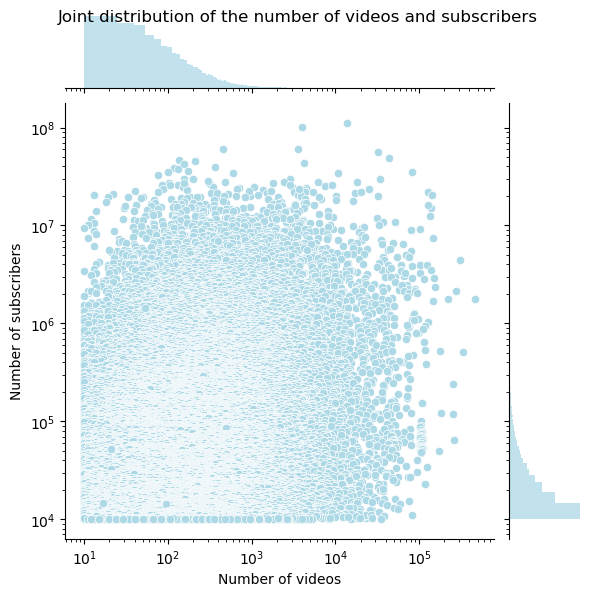

In [6]:
g = sns.jointplot(data=channels_df, x="videos_cc", y="subscribers_cc", color="lightblue");
g.ax_joint.set_xscale('log');
g.ax_joint.set_yscale('log');
g.ax_joint.set_xlabel("Number of videos");
g.ax_joint.set_ylabel("Number of subscribers");
g.fig.suptitle("Joint distribution of the number of videos and subscribers");

#### Number of channels per category


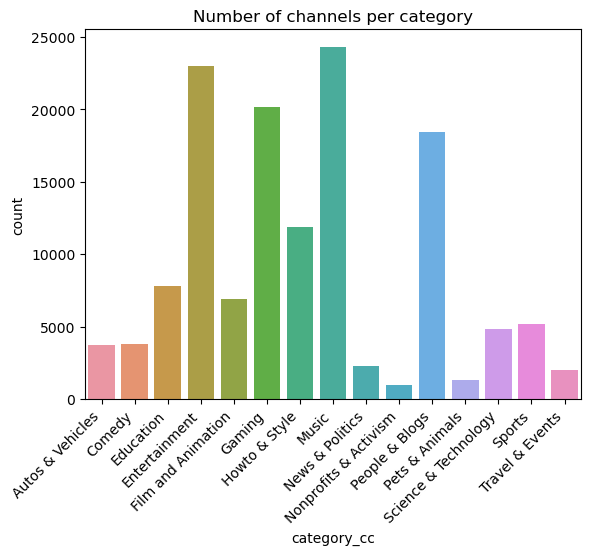

In [7]:
# visualize the distribution of the number of channels per category
sns.countplot(data=channels_df.sort_values(by="category_cc"), x="category_cc")
plt.xticks(rotation=45, ha="right");
plt.title("Number of channels per category");

Music, Entertainment, Gaming, and People&Blogs are the most popular categories across the YouTube channels in the dataset.

#### Distribution of the number of subscribers and the number of videos across YouTube categories

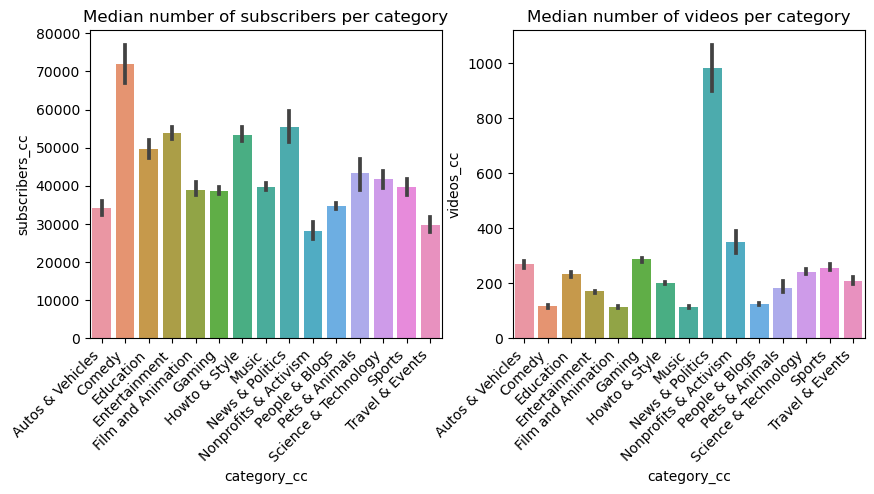

In [8]:
f, ax = plt.subplots(1,2, figsize=(10,4))
plt.subplot(1,2,1)
sns.barplot(data=channels_df.sort_values(by="category_cc"), x="category_cc", y="subscribers_cc", ax = ax[0], estimator=np.median, ci=95)
plt.xticks(rotation=45, ha="right")
plt.title("Median number of subscribers per category")
plt.subplot(1,2,2)
sns.barplot(data=channels_df.sort_values(by="category_cc"), x="category_cc", y="videos_cc", ax = ax[1], estimator=np.median, ci=95)
plt.xticks(rotation=45, ha="right")
plt.title("Median number of videos per category");

These distributions were plotted using the median values of the number of subscribers and of videos of the channels belonging to each category. We observe that, in general, Comedy channels have the highest number of subscribers. As far as videos go, instead, from the histogram we notice that News&Politics channels post the most.

#### Number of videos per category in the Metadata dataframe

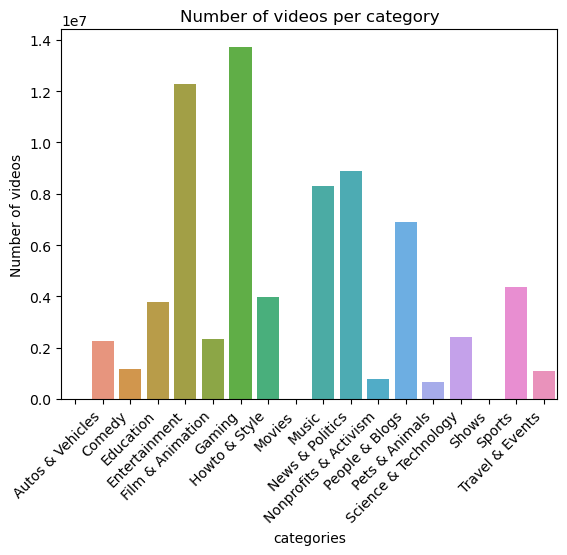

In [9]:
metadata_grouped = metadata_df.groupby("categories").count()['channel_id'].reset_index()
sns.barplot(data=metadata_grouped, x="categories", y='channel_id' )
plt.xticks(rotation=45, ha="right");
plt.ylabel("Number of videos");
plt.title("Number of videos per category");

From this plot, we observe the distribution of the single videos in the `metadata` dataframe. From this, we observe that the most represented categories are Gaming and Entertainment. Moreover, two new categories appear (Movies and Shows) but have just a few number of videos each. 

In [10]:
chan_distr_cat = channels_df.groupby("category_cc").count()["join_date"]

In [11]:
video_distr_categ = metadata_df[metadata_df["categories"]!=''].groupby("categories").count()["channel_id"]

In [12]:
import scipy.stats as scs
scs.ttest_ind(video_distr_categ, chan_distr_cat)

Ttest_indResult(statistic=3.880451509062183, pvalue=0.0005297969044065861)

From the independence t-test we notice the two distributions of channels and videos aren't the same. This will be addressed later.

## Timeseries's dataframe exploration

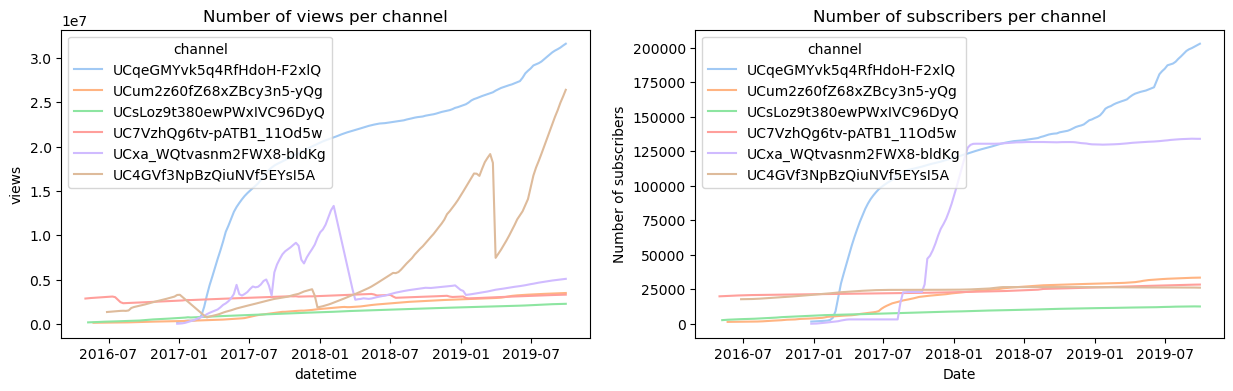

In [13]:
# number of views per channel
import random
# channels_sample = random.sample(list(channels_df["channel"].unique()),6)
current_channel = ['UC4GVf3NpBzQiuNVf5EYsI5A',
 'UC7VzhQg6tv-pATB1_11Od5w',
 'UCxa_WQtvasnm2FWX8-bldKg',
 'UCum2z60fZ68xZBcy3n5-yQg',
 'UCqeGMYvk5q4RfHdoH-F2xlQ',
 'UCsLoz9t380ewPWxIVC96DyQ']
f,ax = plt.subplots(1, 2, figsize=(15,4))
sns.lineplot(data=timeseries_df[timeseries_df['channel'].isin(current_channel)], x="datetime", y="views", hue="channel", ax=ax[0])
ax[0].set_title("Number of views per channel")
plt.xlabel("Date")
plt.ylabel("Number of views")
sns.lineplot(data=timeseries_df[timeseries_df['channel'].isin(current_channel)], x="datetime", y="subs", hue="channel", ax=ax[1])
plt.title("Number of subscribers per channel")
plt.xlabel("Date")
plt.ylabel("Number of subscribers");

From the above plots, it's clear that channels were observed for different periods of time. The observations started at different datetimes and they didn't last for the same amount of time.

## Metadata dataframe exploration

In [14]:
metadata_df.head()

,categories,channel_id,duration,upload_date,like_count,dislike_count,view_count
0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,1159,2016-09-28,8.0,1.0,1057.0
1,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2681,2016-09-28,23.0,1.0,12894.0
2,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,1394,2016-09-28,1607.0,779.0,1800602.0
3,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,5064,2016-09-28,227.0,24.0,57640.0
4,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,3554,2016-09-28,105.0,13.0,86368.0


In [15]:
metadata_df.describe()

,duration,like_count,dislike_count,view_count
count,7.292479e+07,7.129334e+07,7.129334e+07,7.292414e+07
mean,7.576761e+02,1.306758e+03,7.609159e+01,1.252376e+05
std,1.820111e+03,2.013588e+04,3.064758e+03,3.534488e+06
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.340000e+02,6.000000e+00,0.000000e+00,5.320000e+02
50%,2.840000e+02,4.300000e+01,2.000000e+00,2.926000e+03
75%,6.980000e+02,2.650000e+02,1.200000e+01,1.743100e+04
max,3.601570e+05,3.528732e+07,1.691635e+07,6.509934e+09


#### Likes distribution over categories

In [16]:
# Normalization of the number of likes over the number of views per video
metadata_df_likes = metadata_df.copy()
metadata_df_likes["likes_over_views"] = metadata_df_likes['like_count'] / metadata_df_likes['view_count']

# some of the views are 0, so the ratio is infinite, so we remove these videos
metadata_df_likes = metadata_df_likes.loc[metadata_df_likes["likes_over_views"] != np.inf]

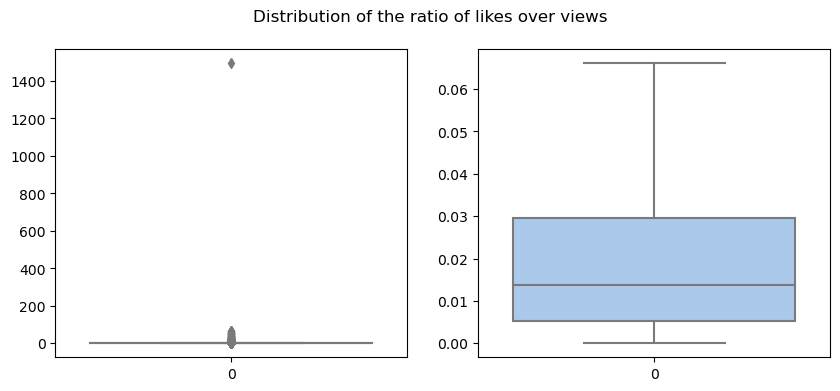

In [17]:
# Visualization of the distribution of the ratio of likes over views
f, ax = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(data=metadata_df_likes.likes_over_views, ax=ax[0]);
sns.boxplot(data=metadata_df_likes.likes_over_views, showfliers=False);
f.suptitle("Distribution of the ratio of likes over views");

There are some videos that have a ratio of number of likes over the number of views higher than 1. This would mean that the number of likes is higher than that of the views, which means there are inconsistencies throughout the dataset.  

In [18]:
# observe the distribution of the likes over the different
metadata_df_likes['likes_views_class'] = pd.cut(metadata_df_likes["likes_over_views"], [0, 0.001, 0.005,0.01, 0.05, 0.1, 0.5,1])
metadata_df_likes_pivot = metadata_df_likes.groupby(["categories", "likes_views_class"]).count().reset_index().pivot("categories", "likes_views_class", values="likes_over_views")
metadata_df_likes_heat = metadata_df_likes_pivot.divide(metadata_df_likes_pivot.sum(axis=1), axis=0)


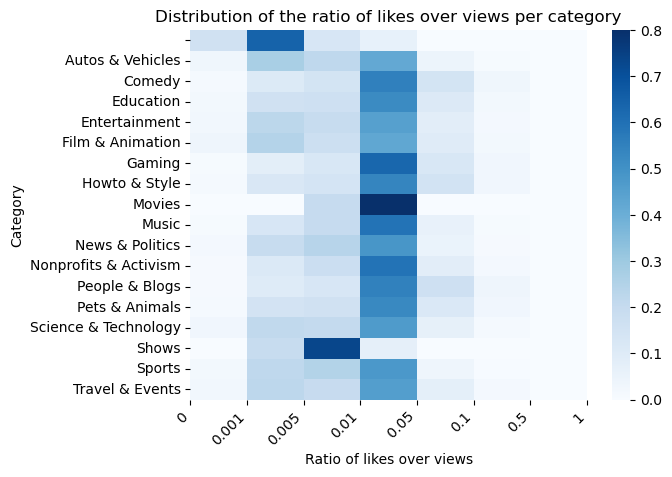

In [19]:
sns.heatmap(metadata_df_likes_heat, cmap="Blues", fmt="d", cbar=True)
plt.xticks(ticks = np.arange(0,8,1), labels=["0","0.001","0.005","0.01"," 0.05", "0.1","0.5","1"], rotation=45, ha="right");
plt.title("Distribution of the ratio of likes over views per category");
plt.ylabel("Category");
plt.xlabel("Ratio of likes over views");

The plot above, shows the distribution of likes over views for each category. The heatmap values represent the proportion of videos of a category that got a specific ratio of likes. Most of the categories receive likes corresponding to the 1% - 5% of views that they obtain. 

#### Disikes distribution over categories

In [20]:
# Normalization of the number of dislikes over the number of views per video
metadata_df_dislikes = metadata_df.copy()
metadata_df_dislikes["dislikes_over_views"] = metadata_df_dislikes['dislike_count'] / metadata_df_dislikes['view_count']

# some of the views are 0, so the ratio is infinite, so we remove these videos
metadata_df_dislikes = metadata_df_dislikes.loc[metadata_df_dislikes["dislikes_over_views"] != np.inf]

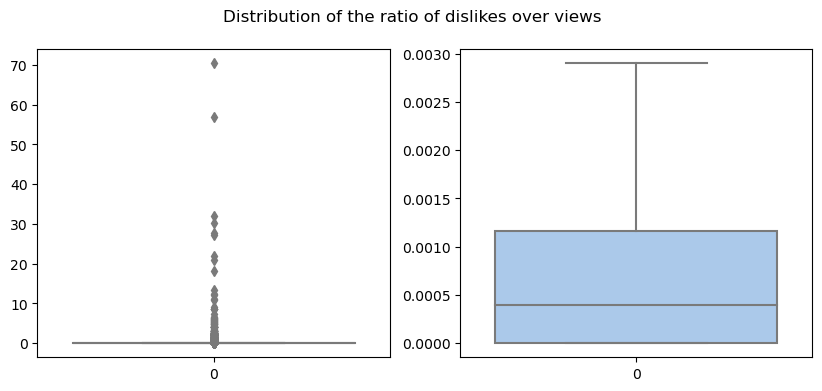

In [21]:
# Visualization of the distribution of the ratio of dislikes over views
f, ax = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(data=metadata_df_dislikes.dislikes_over_views, ax=ax[0]);
sns.boxplot(data=metadata_df_dislikes.dislikes_over_views, showfliers=False);
f.suptitle("Distribution of the ratio of dislikes over views");

There are some videos that have a ratio of number of likes over the number of views higher than 1. This would mean that the number of likes is higher than that of the views, which means there are inconsistencies throughout the dataset.  

In [22]:
# observe the distribution of the dislikes over the different
metadata_df_dislikes['dislikes_views_class'] = pd.cut(metadata_df_dislikes["dislikes_over_views"], [0, 0.001, 0.005,0.01, 0.05, 0.1, 0.5,1])
metadata_df_dislikes_pivot = metadata_df_dislikes.groupby(["categories", "dislikes_views_class"]).count().reset_index().pivot("categories", "dislikes_views_class", values="dislikes_over_views")
metadata_df_dislikes_heat = metadata_df_dislikes_pivot.divide(metadata_df_dislikes_pivot.sum(axis=1), axis=0)


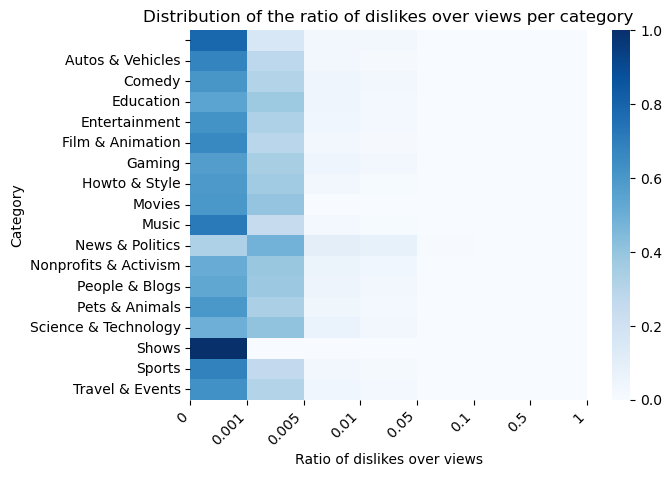

In [23]:
sns.heatmap(metadata_df_dislikes_heat, cmap="Blues", fmt="d", cbar=True)
plt.xticks(ticks = np.arange(0,8,1), labels=["0","0.001","0.005","0.01"," 0.05", "0.1","0.5","1"], rotation=45, ha="right");
plt.title("Distribution of the ratio of dislikes over views per category");
plt.ylabel("Category");
plt.xlabel("Ratio of dislikes over views");

#### Distribution of the number of views per category

In [24]:
metadata_df_views = metadata_df.copy()
metadata_df_views['num_views_cut'] = pd.cut(metadata_df_views["view_count"], [0, 1,10,100,1000,10000,100000,1e10])
metadata_df_views.groupby(["categories", "num_views_cut"]).count()
metadata_df_views_pivot = metadata_df_views.groupby(["categories", "num_views_cut"]).count().reset_index().pivot("categories", "num_views_cut", values="view_count")
metadata_df_views_heat = metadata_df_views_pivot.divide(metadata_df_views_pivot.sum(axis=1), axis=0)

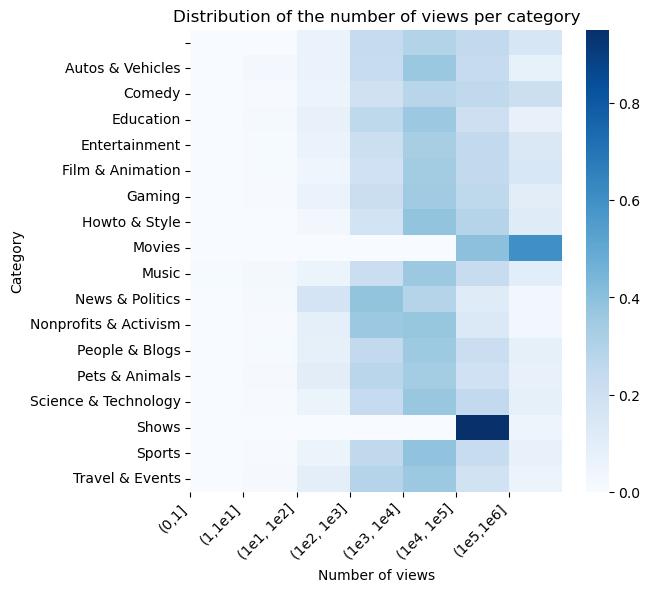

In [25]:
labeling = ["(0,1]", "(1,1e1]", "(1e1, 1e2]", "(1e2, 1e3]", "(1e3, 1e4]", "(1e4, 1e5]", "(1e5,1e6]"]
plt.figure(figsize=(6,6))
g = sns.heatmap(metadata_df_views_heat, cmap="Blues", fmt="d", cbar=True)
plt.xticks(ticks=np.arange(0,7,1), labels=labeling, rotation=45, ha="right");
plt.title("Distribution of the number of views per category", loc="center");
plt.xlabel("Number of views");
plt.ylabel("Category");

## Comparison between channels' and videos' categories distribution

In [26]:
categories_df = channels_df[["channel", "category_cc"]].merge(metadata_df[["channel_id", "categories"]], left_on="channel", right_on="channel_id" )
categories_df.rename(columns={"category_cc": "category_ch", "categories": "category_vid"}, inplace=True)
num_videos_per_chan = categories_df.groupby("channel").count()['channel_id']
cat_grouped = categories_df.groupby(["category_ch", "category_vid", "channel"]).count().reset_index()
cat_grouped['density'] = cat_grouped.apply(lambda x: x["channel_id"] / num_videos_per_chan[x["channel"]], axis=1)
cat_to_heat = cat_grouped.groupby(["category_ch", "category_vid"]).mean().reset_index().pivot("category_ch", "category_vid", "density")

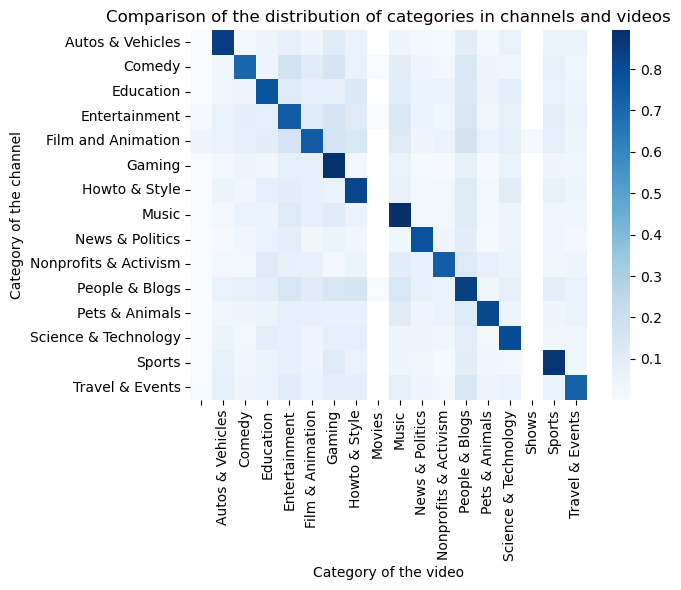

In [27]:
sns.heatmap(cat_to_heat, cmap="Blues", fmt="d", cbar=True)
plt.title("Comparison of the distribution of categories in channels and videos");
plt.xlabel("Category of the video");
plt.ylabel("Category of the channel");